In [89]:
import h5py,torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
df = pd.read_csv('../data/data_danq.txt',sep='\t')
df = df[['Cell Type','TF/DNase/HistoneMark','Treatment']]

In [113]:
#target counts
n_dnases = (df['TF/DNase/HistoneMark']=='DNase').sum()
df[df['TF/DNase/HistoneMark']=='H2AK5ac']
n_hists = len(df.iloc[815:])
n_tfs = len(df) - n_dnases - n_hists
n_dnases, n_tfs, n_hists

(125, 104, 690)

In [35]:
#frequency of each class to weight the average of the metrics
train_h5 = h5py.File('../data/Processed/train.hdf5')
N,M = train_h5['y_train'].shape
class_counts = np.zeros(M,dtype='float32')
bases_counts = np.zeros(4,dtype='int64')
chk_sz = 100_000
for i in range(0,N,chk_sz):
    xs = train_h5['X_train'][i:i+chk_sz]
    unique, counts = np.unique(xs, return_counts=True)
    bases_counts += counts
    ys = train_h5['y_train'][i:i+chk_sz]
    class_counts += ys.sum(0)
train_h5.close()

In [49]:
valid = np.load('../data/Processed/valid.npz')
#X_valid = torch.tensor(valid['arr_0'][:])
y_valid = torch.tensor(valid['arr_1'][:])
vld_class_counts = y_valid.sum(0)

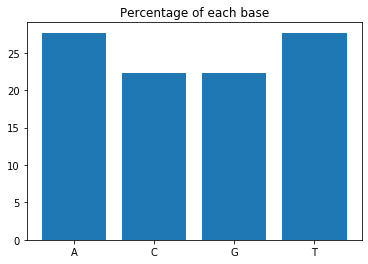

In [48]:
plt.bar([1,2,3,4],bases_counts/bases_counts.sum()*100,tick_label=['A','C','G','T'])
_ = plt.title('Percentage of each base')

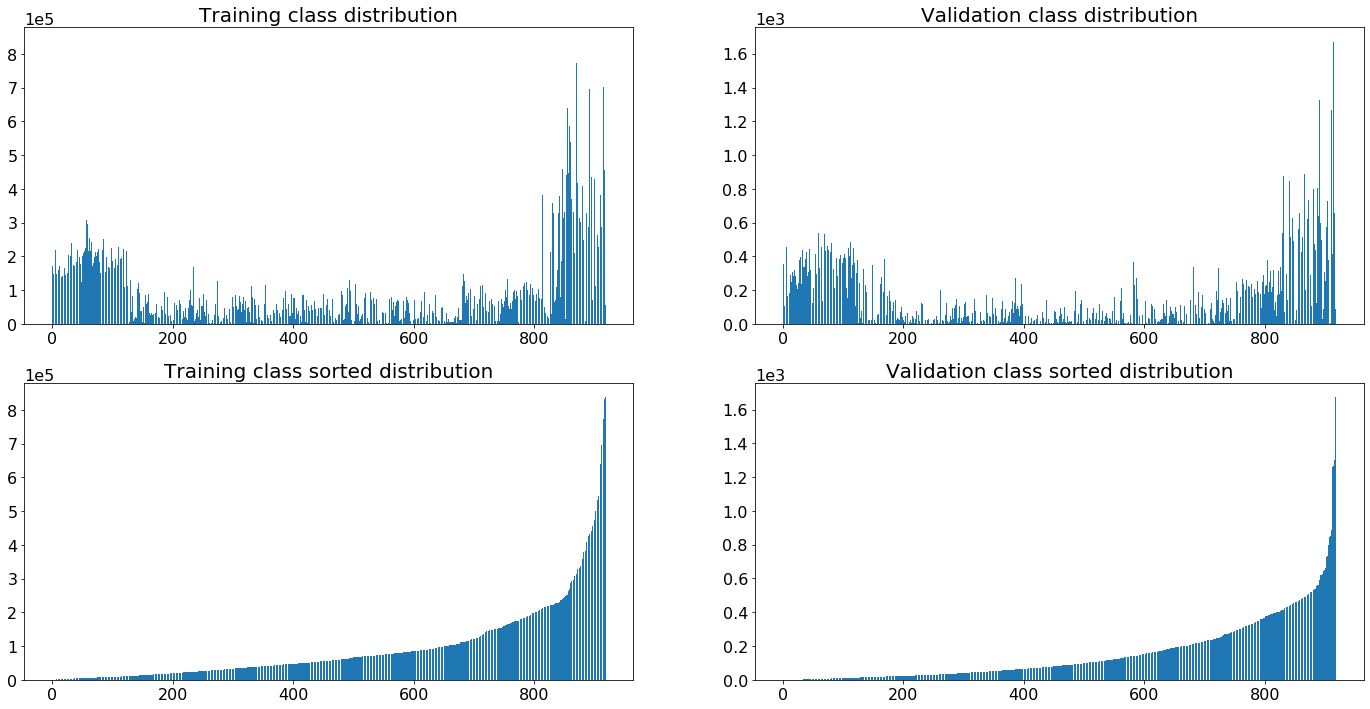

In [147]:
fig, axs = plt.subplots(2, 2,figsize=(24,12))
fts = 20
ft_tick = 16
axs[0,0].bar(list(range(len(class_counts))),class_counts)
axs[0,0].set_title('Training class distribution',fontsize=fts)
axs[0,0].tick_params(axis = 'both', which = 'major', labelsize = ft_tick)
axs[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0,0].yaxis.get_offset_text().set_fontsize(ft_tick)

axs[0,1].bar(list(range(len(vld_class_counts))),vld_class_counts)
axs[0,1].set_title('Validation class distribution',fontsize=fts)
axs[0,1].tick_params(axis = 'both', which = 'major', labelsize = ft_tick)
axs[0,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0,1].yaxis.get_offset_text().set_fontsize(ft_tick)

axs[1,0].bar(list(range(len(class_counts))),sorted(class_counts))
axs[1,0].set_title('Training class sorted distribution',fontsize=fts)
axs[1,0].tick_params(axis = 'both', which = 'major', labelsize = ft_tick)
axs[1,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1,0].yaxis.get_offset_text().set_fontsize(ft_tick)

axs[1,1].bar(list(range(len(vld_class_counts))),sorted(vld_class_counts))
axs[1,1].set_title('Validation class sorted distribution',fontsize=fts)
axs[1,1].tick_params(axis = 'both', which = 'major', labelsize = ft_tick)
axs[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1,1].yaxis.get_offset_text().set_fontsize(ft_tick)

In [65]:
(class_counts==0).sum(),(vld_class_counts==0).sum()

(0, tensor(34))

In [4]:
#postive vs negative total
total = N*M
pos = class_counts.sum()
neg = total - pos
pos/total*100,neg/total*100,neg/pos

(2.161164309031556, 97.83883569096844, 45.27135455740115)

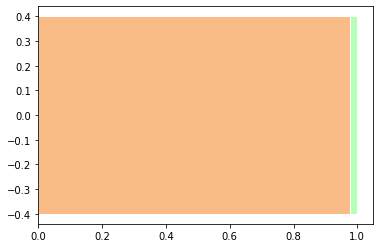

In [5]:
plt.barh([0], neg/total, color='#f9bc86', edgecolor='white')
plt.barh([0], pos/total, left=neg/total, color='#b5ffb9', edgecolor='white')

plt.show() 

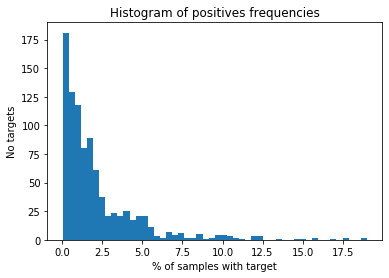

In [152]:
#distribution by class of positives
class_freq = class_counts/N*100
plt.hist(class_freq,50)
plt.xlabel ('% of samples with target')
plt.ylabel ('No targets')
_ = plt.title("Histogram of positives frequencies")

In [76]:
#89% of the postive classes are present in less than 5% of the samples, that is 826/919
class_freq[class_freq<5].size/class_freq.size, (class_freq<5).sum()

(0.8988030467899891, 826)

In [68]:
neg_counts = (N - class_counts).astype('float32')
# the less common negative class if more common than the more frequent postive class
neg_counts.min() > class_counts.max()

True

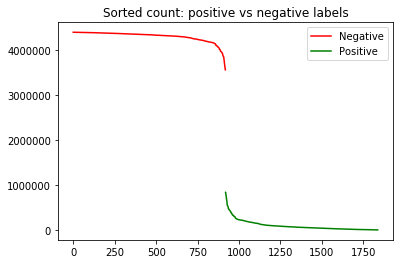

In [134]:
#distribution by class postive and negative separated (look for long tail)
x = np.concatenate([class_counts,neg_counts])
x.sort()
s = x.size//2
plt.plot(np.arange(s),x[::-1][:s],'r',label='Negative')
plt.plot(np.arange(s,2*s),x[::-1][s:],'g',label='Positive')
plt.title("Sorted count: positive vs negative labels")
# _ = plt.axvline(x=s, color='k', linestyle='--')
_ = plt.legend(loc="upper right")

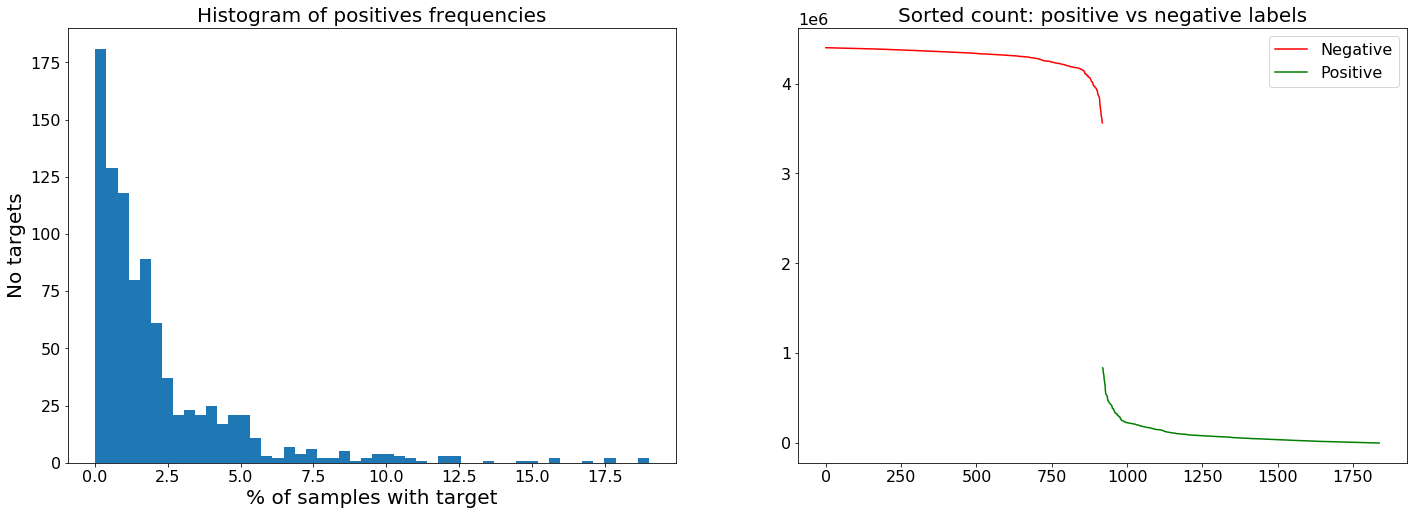

In [171]:
fig, axs = plt.subplots(1, 2,figsize=(24,8))
axs[0].hist(class_freq,50)
axs[0].set_xlabel('% of samples with target',size=20)
axs[0].set_ylabel('No targets',size=20)
axs[0].set_title("Histogram of positives frequencies",fontsize=fts)
axs[0].tick_params(axis = 'both', which = 'major', labelsize = ft_tick)

axs[1].plot(np.arange(s),x[::-1][:s],'r',label='Negative')
axs[1].plot(np.arange(s,2*s),x[::-1][s:],'g',label='Positive')
axs[1].set_title("Sorted count: positive vs negative labels",fontsize=fts)
# _ = plt.axvline(x=s, color='k', linestyle='--')
axs[1].legend(loc="upper right",fontsize=ft_tick)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].tick_params(axis = 'both', which = 'major', labelsize = ft_tick)
axs[1].yaxis.get_offset_text().set_fontsize(ft_tick)

In [ ]:
import torch 
#save class distribution to weights our metrics later
class_weights = class_counts/class_counts.sum()
assert not np.isnan(class_weights).any()
torch.save(torch.from_numpy(class_weights),'../data/Processed/class_weights')